In [33]:

import tensorflow
from  tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import SGD, Adam


## Exploración y preparación

In [34]:
def show_images(data_folder):
    classes = os.listdir(data_folder)
    classes.sort()
    print(f'{len(classes)} classes:')
    fig = plt.figure(figsize=(8, 15))
    for i, sub_dir in enumerate(classes, 1):
        sub_dir_path = os.path.join(data_folder, sub_dir)
        img_files = [f for f in os.listdir(sub_dir_path) if f.endswith('.png') or f.endswith('.jpg')]
        if len(img_files) == 0:
            continue
        img_file = img_files[0]
        img_path = os.path.join(sub_dir_path, img_file)
        img = mpimg.imread(img_path)
        a = fig.add_subplot(1, len(classes), i)
        a.axis('off')
        imgplot = plt.imshow(img)
        a.set_title(img_file)
    plt.show()

2 classes:


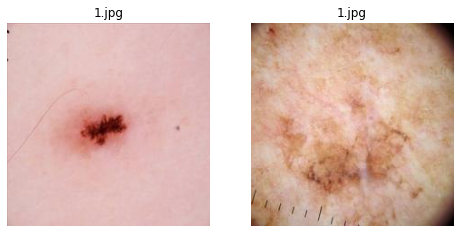

In [35]:
data_folder = 'Cancer/train'
show_images(data_folder)

In [36]:
def prepare_data(data_folder, img_size, batch_size, validation_split):
    print("Getting Data...")
    datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)

    print("Preparing training dataset...")
    train_generator = datagen.flow_from_directory(
        data_folder,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')

    print("Preparing validation dataset...")
    validation_generator = datagen.flow_from_directory(
        data_folder,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation')

    classnames = list(train_generator.class_indices.keys())
    print(f'Data generators ready. Classes: {classnames}')

    return train_generator, validation_generator, classnames

In [37]:
# Define el tamaño de las imágenes, el tamaño del lote y el porcentaje de validación
img_size = (128, 128)
batch_size = 64
validation_split = 0.3

# Prepara los datos de entrenamiento y validación
train_generator, validation_generator, classnames = prepare_data(data_folder, img_size, batch_size, validation_split)

Getting Data...
Preparing training dataset...
Found 8316 images belonging to 2 classes.
Preparing validation dataset...
Found 3563 images belonging to 2 classes.
Data generators ready. Classes: ['Benign', 'Malignant']


## CNN

In [38]:

def build_model(train_generator):
    print("Building model...")
    model = Sequential([
        Conv2D(32, (3, 3), input_shape=train_generator.image_shape, activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation='relu'),  # Capa adicional completamente conectada
        Dense(train_generator.num_classes, activation='softmax')
    ])

    # Compilar el modelo usando el optimizador SGD con momentum
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    print(model.summary())
    return model

def train_model(model, train_generator, validation_generator, num_epochs):
    print("Training model...")
    history = model.fit(
        train_generator,
        steps_per_epoch=30,
        validation_data=validation_generator,
        epochs=num_epochs
    )
    return history

In [39]:
# Construye el modelo
model = build_model(train_generator)

# Entrena el modelo
num_epochs = 95

history = train_model(model, train_generator, validation_generator, num_epochs)

Building model...


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 61, 61, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,232,194 (12.33 MB)

 Trainable params: 3,232,194 (12.33 MB)

 Non-trainable params: 0 (0.00 B)

None
Training model...
Epoch 1/95
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 328ms/step - accuracy: 0.5923 - loss: 0.6597 - val_accuracy: 0.5908 - val_loss: 0.6311
Epoch 2/95
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 307ms/step - accuracy: 0.7534 - loss: 0.5236 - val_accuracy: 0.7095 - val_loss: 0.5192
Epoch 3/95
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 326ms/step - accuracy: 0.8223 - loss: 0.4027 - val_accuracy: 0.7769 - val_loss: 0.5098
Epoch 4/95
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 318ms/step - accuracy: 0.8171 - loss: 0.4097 - val_accuracy: 0.7569 - val_loss: 0.4719
Epoch 5/95
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - accuracy: 0.8189 - loss: 0.3789 - val_accuracy: 0.7303 - val_loss: 0.5035
Epoch 6/95
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 297ms/step - accuracy: 0.8166 - loss: 0.3818 - val_accuracy: 0.7418 - val_loss: 0.4914
Epoch 7/95
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 290ms/step - accuracy: 0.8395 - loss: 0.3562 - val_accuracy: 0.7895 - val_loss: 0.4394
Epoch 8/95
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 302ms/step - accuracy: 0.8484 - loss: 

## Evaluación

In [40]:
def plot_loss(history, num_epochs):
    epoch_nums = range(1, num_epochs + 1)
    training_loss = history.history["loss"]
    validation_loss = history.history["val_loss"]
    plt.plot(epoch_nums, training_loss)
    plt.plot(epoch_nums, validation_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.tight_layout()
    #plt.savefig('../resultados/learning_curve_cnn.png')
    plt.show()

def evaluate_model(model, validation_generator, classes):
    print("Generating predictions from validation data...")
    x_test = validation_generator[0][0]
    y_test = validation_generator[0][1]
    class_probabilities = model.predict(x_test)
    predictions = np.argmax(class_probabilities, axis=1)
    true_labels = np.argmax(y_test, axis=1)
    cm = confusion_matrix(true_labels, predictions)
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=85)
    plt.yticks(tick_marks, classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    print("Evaluating model accuracy...")
    test_loss, test_accuracy = model.evaluate(validation_generator)
    print('Test loss:', test_loss)
    print('Test accuracy:', test_accuracy)

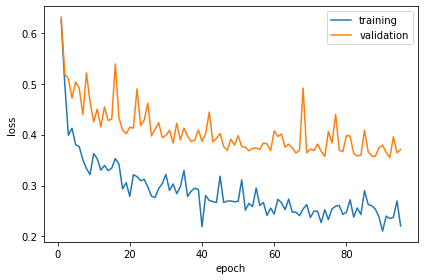

Generating predictions from validation data...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 


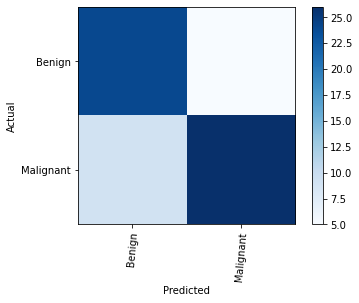

Evaluating model accuracy...
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.8471 - loss: 0.3715
Test loss: 0.3711741864681244
Test accuracy: 0.847038984298706


In [41]:
plot_loss(history, num_epochs)
evaluate_model(model, validation_generator, classnames)

In [42]:
'''
# Save the trained model
modelFileName = '../modelos/logo_classifier.keras'
model.save(modelFileName)
del model  # deletes the existing model variable
print('model saved as', modelFileName)
'''

"\n# Save the trained model\nmodelFileName = '../modelos/logo_classifier.keras'\nmodel.save(modelFileName)\ndel model  # deletes the existing model variable\nprint('model saved as', modelFileName)\n"